In [1]:
import pandas as pd
import numpy as np
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import sktime 
import tslearn
import pyts

In [2]:
lead = 1
obs = 6

In [12]:
patient_data = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_data_set.csv".format(lead, obs, lead, obs))
patient_data.rename(columns={"patientunitstayid" : "PatientStayID", "delirium?" : "Class"}, inplace=True)
patient_data.drop(columns=["del_start", "index"], inplace=True)
patient_data

,PatientStayID,Class,start,end
0,150934,1,406.0,766.0
1,151708,1,1587.0,1947.0
2,152171,1,1960.0,2320.0
3,155126,1,3101.0,3461.0
4,156970,1,17579.0,17939.0
...,...,...,...,...
21429,3352487,0,300.0,660.0
21430,3352563,0,870.0,1230.0
21431,3352747,0,466.0,826.0
21432,3353044,0,2978.0,3338.0


In [39]:
hr = pd.read_csv("../csv/raw_pts/raw_pts_hr.csv")

reformatted_hr = {}
for c, row in patient_data.iterrows():
    patid = row["PatientStayID"]
    temp_table = hr[hr.patientunitstayid==patid]
    temp_table = temp_table[(temp_table['offset'] >= row["start"]) & (temp_table['offset'] <= row["end"])]
    temp_table["offset"] = temp_table["offset"] - row["start"]
    temp_time_series = np.empty(obs*12)
    temp_time_series[:] = np.nan

    for i in range(len(temp_table.index)):
        new_row = temp_table.iloc[i,:]
        ind = int(new_row["offset"]/5)
        if np.isnan(new_row["value"]) or ind >= obs*12:
            continue
        elif np.isnan(temp_time_series[ind]) == False:
            temp_time_series[ind] = (temp_time_series[ind] + new_row["value"])/2
        else:
            temp_time_series[ind] = new_row["value"]
    reformatted_hr[patid] = temp_time_series

final_dict = {"PatientStayID" : [], "HR" : []}
for key in reformatted_hr.keys():
    final_dict["PatientStayID"].append(key)
    final_dict["HR"].append(reformatted_hr[key])
hr_table = pd.DataFrame.from_dict(final_dict)

with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_hr".format(lead, obs), "wb") as f:
    pickle.dump(hr_table, f)

In [40]:
resp = pd.read_csv("../csv/raw_pts/raw_pts_resp.csv")

reformatted_resp = {}
for c, row in patient_data.iterrows():
    patid = row["PatientStayID"]
    temp_table = resp[resp.patientunitstayid==patid]
    temp_table = temp_table[(temp_table['offset'] >= row["start"]) & (temp_table['offset'] <= row["end"])]
    temp_table["offset"] = temp_table["offset"] - row["start"]
    temp_time_series = np.empty(obs*12)
    temp_time_series[:] = np.nan

    for i in range(len(temp_table.index)):
        new_row = temp_table.iloc[i,:]
        ind = int(new_row["offset"]/5)
        if np.isnan(new_row["value"]) or ind >= obs*12:
            continue
        elif np.isnan(temp_time_series[ind]) == False:
            temp_time_series[ind] = (temp_time_series[ind] + new_row["value"])/2
        else:
            temp_time_series[ind] = new_row["value"]
    reformatted_resp[patid] = temp_time_series

final_dict = {"PatientStayID" : [], "Resp" : []}
for key in reformatted_resp.keys():
    final_dict["PatientStayID"].append(key)
    final_dict["Resp"].append(reformatted_resp[key])
resp_table = pd.DataFrame.from_dict(final_dict)

with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_resp".format(lead, obs), "wb") as f:
    pickle.dump(resp_table, f)

In [41]:
sao2 = pd.read_csv("../csv/raw_pts/raw_pts_sao2.csv")

reformatted_sao2 = {}
for c, row in patient_data.iterrows():
    patid = row["PatientStayID"]
    temp_table = sao2[sao2.patientunitstayid==patid]
    temp_table = temp_table[(temp_table['offset'] >= row["start"]) & (temp_table['offset'] <= row["end"])]
    temp_table["offset"] = temp_table["offset"] - row["start"]
    temp_time_series = np.empty(obs*12)
    temp_time_series[:] = np.nan

    for i in range(len(temp_table.index)):
        new_row = temp_table.iloc[i,:]
        ind = int(new_row["offset"]/5)
        if np.isnan(new_row["value"]) or ind >= obs*12:
            continue
        elif np.isnan(temp_time_series[ind]) == False:
            temp_time_series[ind] = (temp_time_series[ind] + new_row["value"])/2
        else:
            temp_time_series[ind] = new_row["value"]
    reformatted_sao2[patid] = temp_time_series

final_dict = {"PatientStayID" : [], "Sao2" : []}
for key in reformatted_sao2.keys():
    final_dict["PatientStayID"].append(key)
    final_dict["Sao2"].append(reformatted_sao2[key])
sao2_table = pd.DataFrame.from_dict(final_dict)

with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_sao2".format(lead, obs), "wb") as f:
    pickle.dump(sao2_table, f)

In [3]:
with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_hr".format(lead, obs), "rb") as f:
    hr_table = pickle.load(f)

with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_resp".format(lead, obs), "rb") as f:
    resp_table = pickle.load(f)

with open("../pickle/relative_{}hr_lead_{}hr_obs/raw_pts/raw_sao2".format(lead, obs), "rb") as f:
    sao2_table = pickle.load(f)

In [4]:
full = hr_table.merge(resp_table, how="outer", on="PatientStayID")
full = full.merge(sao2_table, how="outer", on="PatientStayID")
full

,PatientStayID,HR,Resp,Sao2
0,150934.0,"[88.0, 87.0, 88.0, 79.0, 73.0, 82.0, 94.0, 91....","[31.0, 31.0, 36.0, 23.0, 23.0, 28.0, 44.0, 34....","[80.3333333333333, 81.6666666666667, 83.0, 95...."
1,151708.0,"[72.0, 70.0, 72.0, 80.0, 76.0, 76.0, 70.0, 70....","[11.0, 12.0, 13.0, 14.0, 10.0, 13.0, 10.0, 11....","[98.0, 98.0, 97.0, 98.0, 99.0, 99.0, 99.0, 99...."
2,152171.0,"[72.0, 71.0, 69.0, 70.0, 70.0, 67.0, 63.0, 62....","[24.0, 23.0, 24.0, 22.0, 23.0, 23.0, 24.0, 23....","[98.0, 97.0, 96.0, 98.0, 98.0, 97.0, 98.0, 98...."
3,155126.0,"[98.0, 82.0, 83.0, 81.0, 83.0, 85.0, 82.0, 86....","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....","[98.5333333333333, 98.4666666666667, 98.4, 98...."
4,156970.0,"[70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70....","[13.0, 13.0, 13.0, 13.0, 13.0, 19.0, 18.0, 20....","[97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96...."
...,...,...,...,...
21429,3352487.0,"[92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[21.0, 22.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21....","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93...."
21430,3352563.0,"[57.0, 58.0, 58.0, 59.0, 60.0, 62.0, 62.0, 63....","[17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16....","[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99...."
21431,3352747.0,"[57.0, 55.0, 56.0, 58.0, 59.0, 57.0, 58.0, 65....","[15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 17....","[96.375, 96.3645833333333, 96.3541666666667, 9..."
21432,3353044.0,"[63.0, 61.0, 60.0, 64.0, 63.0, 61.0, 60.0, 60....","[25.0, 19.0, 19.0, 29.0, 20.0, 20.0, 20.0, 20....","[89.4666666666667, 89.0, 93.0, 93.461538461538..."


In [5]:
full = full.dropna(0)
full

,PatientStayID,HR,Resp,Sao2
0,150934.0,"[88.0, 87.0, 88.0, 79.0, 73.0, 82.0, 94.0, 91....","[31.0, 31.0, 36.0, 23.0, 23.0, 28.0, 44.0, 34....","[80.3333333333333, 81.6666666666667, 83.0, 95...."
1,151708.0,"[72.0, 70.0, 72.0, 80.0, 76.0, 76.0, 70.0, 70....","[11.0, 12.0, 13.0, 14.0, 10.0, 13.0, 10.0, 11....","[98.0, 98.0, 97.0, 98.0, 99.0, 99.0, 99.0, 99...."
2,152171.0,"[72.0, 71.0, 69.0, 70.0, 70.0, 67.0, 63.0, 62....","[24.0, 23.0, 24.0, 22.0, 23.0, 23.0, 24.0, 23....","[98.0, 97.0, 96.0, 98.0, 98.0, 97.0, 98.0, 98...."
3,155126.0,"[98.0, 82.0, 83.0, 81.0, 83.0, 85.0, 82.0, 86....","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....","[98.5333333333333, 98.4666666666667, 98.4, 98...."
4,156970.0,"[70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70....","[13.0, 13.0, 13.0, 13.0, 13.0, 19.0, 18.0, 20....","[97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96...."
...,...,...,...,...
21429,3352487.0,"[92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[21.0, 22.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21....","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93...."
21430,3352563.0,"[57.0, 58.0, 58.0, 59.0, 60.0, 62.0, 62.0, 63....","[17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16....","[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99...."
21431,3352747.0,"[57.0, 55.0, 56.0, 58.0, 59.0, 57.0, 58.0, 65....","[15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 17....","[96.375, 96.3645833333333, 96.3541666666667, 9..."
21432,3353044.0,"[63.0, 61.0, 60.0, 64.0, 63.0, 61.0, 60.0, 60....","[25.0, 19.0, 19.0, 29.0, 20.0, 20.0, 20.0, 20....","[89.4666666666667, 89.0, 93.0, 93.461538461538..."


In [6]:
full.iloc[1,2]

array([11., 12., 13., 14., 10., 13., 10., 11., 15., 12., 20., 14., 14.,
       17., 13., 14., 16., 10., 13., 22., 19., 12., 12., 14., 13., 13.,
       18., 25., 25., 24., 21., 12., 14., 15., 13., 12., 13., 17., 12.,
       16., 12., 14., 21., 11., 16., 11., 13., 17., 16., 19., 13., 15.,
       17., 15., 16., 17., 17., 13., 11., 14., 20., 12., 13., 14., 18.,
       21., 13., 12., 11.,  9., 12., 12.])

In [7]:
other = pd.read_csv("../csv/relative_{}hr_lead_{}hr_obs_data/relative_{}hr_lead_{}hr_obs_patientstayid_list.csv".format(lead, obs, lead, obs))
other.drop(columns=["LOS"], inplace=True)
full = other.merge(full, how="inner", left_on="PatientStayID", right_on="PatientStayID")

full

,PatientStayID,Class,HR,Resp,Sao2
0,150934,1,"[88.0, 87.0, 88.0, 79.0, 73.0, 82.0, 94.0, 91....","[31.0, 31.0, 36.0, 23.0, 23.0, 28.0, 44.0, 34....","[80.3333333333333, 81.6666666666667, 83.0, 95...."
1,151708,1,"[72.0, 70.0, 72.0, 80.0, 76.0, 76.0, 70.0, 70....","[11.0, 12.0, 13.0, 14.0, 10.0, 13.0, 10.0, 11....","[98.0, 98.0, 97.0, 98.0, 99.0, 99.0, 99.0, 99...."
2,152171,1,"[72.0, 71.0, 69.0, 70.0, 70.0, 67.0, 63.0, 62....","[24.0, 23.0, 24.0, 22.0, 23.0, 23.0, 24.0, 23....","[98.0, 97.0, 96.0, 98.0, 98.0, 97.0, 98.0, 98...."
3,155126,1,"[98.0, 82.0, 83.0, 81.0, 83.0, 85.0, 82.0, 86....","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....","[98.5333333333333, 98.4666666666667, 98.4, 98...."
4,156970,1,"[70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70....","[13.0, 13.0, 13.0, 13.0, 13.0, 19.0, 18.0, 20....","[97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96...."
...,...,...,...,...,...
21429,3352487,0,"[92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[21.0, 22.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21....","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93...."
21430,3352563,0,"[57.0, 58.0, 58.0, 59.0, 60.0, 62.0, 62.0, 63....","[17.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16....","[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99...."
21431,3352747,0,"[57.0, 55.0, 56.0, 58.0, 59.0, 57.0, 58.0, 65....","[15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 17....","[96.375, 96.3645833333333, 96.3541666666667, 9..."
21432,3353044,0,"[63.0, 61.0, 60.0, 64.0, 63.0, 61.0, 60.0, 60....","[25.0, 19.0, 19.0, 29.0, 20.0, 20.0, 20.0, 20....","[89.4666666666667, 89.0, 93.0, 93.461538461538..."


In [8]:
# Remove patients with more than half missing per dataset

for i in range(len(full.index)):
    if np.sum(np.isnan(full.iloc[i, 2])) > 5 or np.sum(np.isnan(full.iloc[i, 3])) > 5 or np.sum(np.isnan(full.iloc[i, 4])) > 5:
        full.iloc[i, 2] = np.nan
full = full.dropna()
full

,PatientStayID,Class,HR,Resp,Sao2
0,150934,1,"[88.0, 87.0, 88.0, 79.0, 73.0, 82.0, 94.0, 91....","[31.0, 31.0, 36.0, 23.0, 23.0, 28.0, 44.0, 34....","[80.3333333333333, 81.6666666666667, 83.0, 95...."
1,151708,1,"[72.0, 70.0, 72.0, 80.0, 76.0, 76.0, 70.0, 70....","[11.0, 12.0, 13.0, 14.0, 10.0, 13.0, 10.0, 11....","[98.0, 98.0, 97.0, 98.0, 99.0, 99.0, 99.0, 99...."
2,152171,1,"[72.0, 71.0, 69.0, 70.0, 70.0, 67.0, 63.0, 62....","[24.0, 23.0, 24.0, 22.0, 23.0, 23.0, 24.0, 23....","[98.0, 97.0, 96.0, 98.0, 98.0, 97.0, 98.0, 98...."
3,155126,1,"[98.0, 82.0, 83.0, 81.0, 83.0, 85.0, 82.0, 86....","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....","[98.5333333333333, 98.4666666666667, 98.4, 98...."
4,156970,1,"[70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70....","[13.0, 13.0, 13.0, 13.0, 13.0, 19.0, 18.0, 20....","[97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96...."
...,...,...,...,...,...
21428,3352386,0,"[107.0, 103.0, 106.0, 109.0, 116.0, 109.0, 109...","[22.0, 21.0, 22.0, 22.0, 26.0, 20.0, 22.0, 21....","[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99...."
21429,3352487,0,"[92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[21.0, 22.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21....","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93...."
21431,3352747,0,"[57.0, 55.0, 56.0, 58.0, 59.0, 57.0, 58.0, 65....","[15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 17....","[96.375, 96.3645833333333, 96.3541666666667, 9..."
21432,3353044,0,"[63.0, 61.0, 60.0, 64.0, 63.0, 61.0, 60.0, 60....","[25.0, 19.0, 19.0, 29.0, 20.0, 20.0, 20.0, 20....","[89.4666666666667, 89.0, 93.0, 93.461538461538..."


In [9]:
# Process HR missing data

for i in range(len(full.index)):
    temp_array = full.iloc[i, 2]
    temp_df = pd.DataFrame(temp_array)
    temp_df.fillna(method='ffill', axis=0, inplace=True)
    temp_df.fillna(method='bfill', axis=0, inplace=True)
    temp_array = temp_df.to_numpy().flatten()
    full.iloc[i, 2][:] = temp_array

    temp_array = full.iloc[i, 3]
    temp_df = pd.DataFrame(temp_array)
    temp_df.fillna(method='ffill', axis=0, inplace=True)
    temp_df.fillna(method='bfill', axis=0, inplace=True)
    temp_array = temp_df.to_numpy().flatten()
    full.iloc[i, 3][:] = temp_array

    temp_array = full.iloc[i, 4]
    temp_df = pd.DataFrame(temp_array)
    temp_df.fillna(method='ffill', axis=0, inplace=True)
    temp_df.fillna(method='bfill', axis=0, inplace=True)
    temp_array = temp_df.to_numpy().flatten()
    full.iloc[i, 4][:] = temp_array

full

,PatientStayID,Class,HR,Resp,Sao2
0,150934,1,"[88.0, 87.0, 88.0, 79.0, 73.0, 82.0, 94.0, 91....","[31.0, 31.0, 36.0, 23.0, 23.0, 28.0, 44.0, 34....","[80.3333333333333, 81.6666666666667, 83.0, 95...."
1,151708,1,"[72.0, 70.0, 72.0, 80.0, 76.0, 76.0, 70.0, 70....","[11.0, 12.0, 13.0, 14.0, 10.0, 13.0, 10.0, 11....","[98.0, 98.0, 97.0, 98.0, 99.0, 99.0, 99.0, 99...."
2,152171,1,"[72.0, 71.0, 69.0, 70.0, 70.0, 67.0, 63.0, 62....","[24.0, 23.0, 24.0, 22.0, 23.0, 23.0, 24.0, 23....","[98.0, 97.0, 96.0, 98.0, 98.0, 97.0, 98.0, 98...."
3,155126,1,"[98.0, 82.0, 83.0, 81.0, 83.0, 85.0, 82.0, 86....","[20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20....","[98.5333333333333, 98.4666666666667, 98.4, 98...."
4,156970,1,"[70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70.0, 70....","[13.0, 13.0, 13.0, 13.0, 13.0, 19.0, 18.0, 20....","[97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 97.0, 96...."
...,...,...,...,...,...
21428,3352386,0,"[107.0, 103.0, 106.0, 109.0, 116.0, 109.0, 109...","[22.0, 21.0, 22.0, 22.0, 26.0, 20.0, 22.0, 21....","[99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99.0, 99...."
21429,3352487,0,"[92.0, 93.0, 94.0, 94.0, 94.0, 94.0, 94.0, 95....","[21.0, 22.0, 21.0, 21.0, 22.0, 21.0, 21.0, 21....","[94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 93...."
21431,3352747,0,"[57.0, 55.0, 56.0, 58.0, 59.0, 57.0, 58.0, 65....","[15.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 17....","[96.375, 96.3645833333333, 96.3541666666667, 9..."
21432,3353044,0,"[63.0, 61.0, 60.0, 64.0, 63.0, 61.0, 60.0, 60....","[25.0, 19.0, 19.0, 29.0, 20.0, 20.0, 20.0, 20....","[89.4666666666667, 89.0, 93.0, 93.461538461538..."


In [10]:
patids = full["PatientStayID"]
patids

labels = full["Class"]

In [11]:
def compute_barycenter(ts):
    barycenter_mean = np.zeros(len(ts[0]))
    barycenter_std = np.zeros(len(ts[0]))

    for i in range(len(barycenter_mean)):
        barycenter_mean[i] = np.mean(ts[:, i].ravel())
        barycenter_std[i] = np.std(ts[:, i].ravel())
    return barycenter_mean, barycenter_std

12324
3279


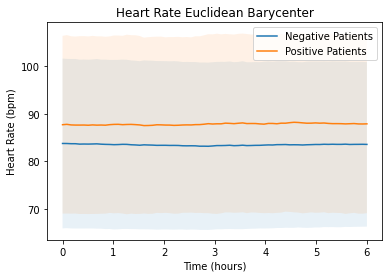

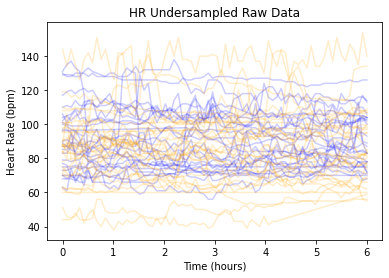

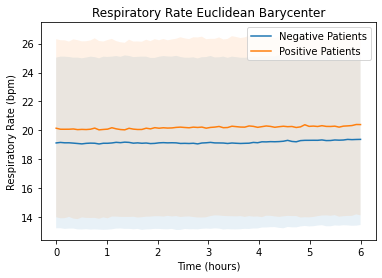

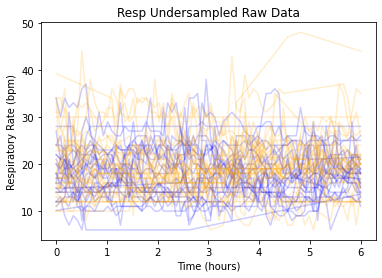

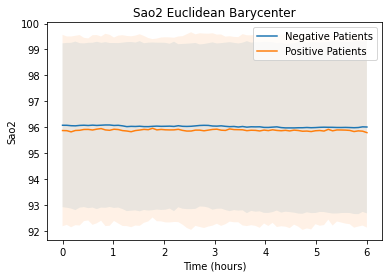

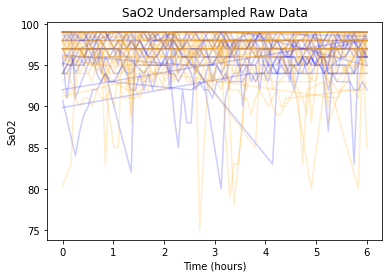

In [12]:
# Barycenters with Euclidean Distance
from tslearn.barycenters import euclidean_barycenter

ts_data = np.zeros((len(full.index), obs*12, 3))


for i in range(len(full.index)):
    ts_data[i, :, 0] = full.iloc[i, 2]
    ts_data[i, :, 1] = full.iloc[i, 3]
    ts_data[i, :, 2] = full.iloc[i, 4]


X_hr_0 = ts_data[labels==0, :, 0]
print(len(X_hr_0))
X_hr_1 = ts_data[labels==1, :, 0]
print(len(X_hr_1))

X_resp_0 = ts_data[labels==0, :, 1]
X_resp_1 = ts_data[labels==1, :, 1]

X_sao2_0 = ts_data[labels==0, :, 2]
X_sao2_1 = ts_data[labels==1, :, 2]




plt.figure()
plt.title("Heart Rate Euclidean Barycenter")
X_hr_0_barycenter = compute_barycenter(X_hr_0)
X_hr_1_barycenter = compute_barycenter(X_hr_1)
plt.plot(np.linspace(0, obs, obs*12), X_hr_0_barycenter[0])
plt.fill_between(np.linspace(0, obs, obs*12), X_hr_0_barycenter[0]-X_hr_0_barycenter[1], X_hr_0_barycenter[0]+X_hr_0_barycenter[1], alpha=0.1)
plt.plot(np.linspace(0, obs, obs*12), X_hr_1_barycenter[0])
plt.fill_between(np.linspace(0, obs, obs*12), X_hr_1_barycenter[0]-X_hr_1_barycenter[1], X_hr_1_barycenter[0]+X_hr_1_barycenter[1], alpha=0.1)
plt.legend(["Negative Patients", "Positive Patients"])
plt.xlabel("Time (hours)")
plt.ylabel("Heart Rate (bpm)")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/hr_euclidean.png".format(lead, obs))
plt.show()

plt.figure()
plt.title("HR Undersampled Raw Data")
for i, series in enumerate(X_hr_0):
    if i % 500 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "b-", alpha=.2)
for i, series in enumerate(X_hr_1):
    if i % 100 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "-", color='orange', alpha=.2)
plt.xlabel("Time (hours)")
plt.ylabel("Heart Rate (bpm)")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/hr_undersampled.png".format(lead, obs))
plt.show()


plt.figure()
plt.title("Respiratory Rate Euclidean Barycenter")
X_resp_0_barycenter = compute_barycenter(X_resp_0)
X_resp_1_barycenter = compute_barycenter(X_resp_1)
plt.plot(np.linspace(0, obs, 12*obs), X_resp_0_barycenter[0])
plt.fill_between(np.linspace(0, obs, 12*obs), X_resp_0_barycenter[0]-X_resp_0_barycenter[1], X_resp_0_barycenter[0]+X_resp_0_barycenter[1], alpha=0.1)
plt.plot(np.linspace(0, obs, 12*obs), X_resp_1_barycenter[0])
plt.fill_between(np.linspace(0, obs, 12*obs), X_resp_1_barycenter[0]-X_resp_1_barycenter[1], X_resp_1_barycenter[0]+X_resp_1_barycenter[1], alpha=0.1)
plt.legend(["Negative Patients", "Positive Patients"])
plt.xlabel("Time (hours)")
plt.ylabel("Respiratory Rate (bpm)")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/resp_euclidean.png".format(lead, obs))
plt.show()

plt.figure()
plt.title("Resp Undersampled Raw Data")
for i, series in enumerate(X_resp_0):
    if i % 500 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "b-", alpha=.2)
for i, series in enumerate(X_resp_1):
    if i % 100 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "-", color='orange', alpha=.2)
plt.xlabel("Time (hours)")
plt.ylabel("Respiratory Rate (bpm)")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/resp_undersampled.png".format(lead, obs))
plt.show()

plt.figure()
plt.title("Sao2 Euclidean Barycenter")
X_sao2_0_barycenter = compute_barycenter(X_sao2_0)
X_sao2_1_barycenter = compute_barycenter(X_sao2_1)
plt.plot(np.linspace(0, obs, 12*obs), X_sao2_0_barycenter[0])
plt.fill_between(np.linspace(0, obs, 12*obs), X_sao2_0_barycenter[0]-X_sao2_0_barycenter[1], X_sao2_0_barycenter[0]+X_sao2_0_barycenter[1], alpha=0.1)
plt.plot(np.linspace(0, obs, 12*obs), X_sao2_1_barycenter[0])
plt.fill_between(np.linspace(0, obs, 12*obs), X_sao2_1_barycenter[0]-X_sao2_1_barycenter[1], X_sao2_1_barycenter[0]+X_sao2_1_barycenter[1], alpha=0.1)
plt.legend(["Negative Patients", "Positive Patients"])
plt.xlabel("Time (hours)")
plt.ylabel("Sao2")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/sao2_euclidean.png".format(lead, obs))
plt.show()

plt.figure()
plt.title("SaO2 Undersampled Raw Data")
for i, series in enumerate(X_sao2_0):
    if i % 500 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "b-", alpha=.2)
for i, series in enumerate(X_sao2_1):
    if i % 100 == 0:
        plt.plot(np.linspace(0, obs, 12*obs), series.ravel(), "-", color='orange', alpha=.2)
plt.xlabel("Time (hours)")
plt.ylabel("SaO2")
plt.savefig("../figures/relative_{}hr_lead_{}hr_obs/pts_time_series_only/sao2_undersampled.png".format(lead, obs))
plt.show()
#X_train, X_test, y_train, y_test = train_test_split(ts_data, labels, test_size=0.01, random_state=42)

In [13]:

from tsfresh.feature_extraction.feature_calculators import permutation_entropy 

def extract_pts_feature(ts_table, column=2, window_size=1):
    extracted_features = {"PatientStayID" : [],
                          "mean_mean" : [],
                          "mean_min" : [],
                          "mean_max" : [],
                          "mean_std" : [],
                          "mean_range" : [],
                          "min_mean" : [],
                          "min_min" : [],
                          "min_max" : [],
                          "min_std" : [],
                          "min_range" : [],
                          "max_mean" : [],
                          "max_min" : [],
                          "max_max" : [],
                          "max_std" : [],
                          "max_range" : [], 
                          "std_mean" : [],
                          "std_min" : [],
                          "std_max" : [],
                          "std_std" : [],
                          "std_range" : [], 
                          "range_mean" : [],
                          "range_min" : [],
                          "range_max" : [],
                          "range_std" : [],
                          "range_range" : [],
                          "delta_mean" : [],
                          "delta_min" : [],
                          "delta_max" : [],
                          "delta_std" : [],
                          "delta_range" : [],
                          "delta_final" : [],
                          "permutation_entropy_d_3" : [],
                          "permutation_entropy_d_4" : [],
                          "permutation_entropy_d_5" : [],
                          "permutation_entropy_d_6" : [],
                          "permutation_entropy_d_7" : [],
                          "permutation_entropy_d_8" : [],
                          "permutation_entropy_d_9" : [],
                          "permutation_entropy_d_10" : [],
                          }
    for i in range(len(ts_table.index)):
        extracted_features["PatientStayID"].append(ts_table.iloc[i, 0])
        
        for d in range(3, 11):
            extracted_features["permutation_entropy_d_{}".format(d)].append(permutation_entropy(ts_table.iloc[i, column],tau=1, dimension=d))

        num_windows = int(len(ts_table.iloc[0, column])/(12*window_size))
        temp_data = np.zeros((6, num_windows))

        for j in range(num_windows):
            temp_ts = ts_table.iloc[i, column][j*12*window_size:(j+1)*12*window_size]
            temp_data[0, j] = np.mean(temp_ts)
            temp_data[1, j] = np.min(temp_ts)
            temp_data[2, j] = np.max(temp_ts)
            temp_data[3, j] = np.std(temp_ts)
            temp_data[4, j] = np.max(temp_ts) - np.min(temp_ts)
            temp_data[5, j] = temp_ts[-1] - temp_ts[0]
        
        feature_names = ["mean", "min", "max", "std", "range", "delta"]
        for j in range(6):
            extracted_features["{}_mean".format(feature_names[j])].append(np.mean(temp_data[j, :]))
            extracted_features["{}_min".format(feature_names[j])].append(np.min(temp_data[j, :]))
            extracted_features["{}_max".format(feature_names[j])].append(np.max(temp_data[j, :]))
            extracted_features["{}_std".format(feature_names[j])].append(np.std(temp_data[j, :]))
            extracted_features["{}_range".format(feature_names[j])].append(np.max(temp_data[j, :]) - np.min(temp_data[j, :]))
        
        extracted_features["delta_final"].append(np.sum(temp_data[5, :]))
    
    return(pd.DataFrame.from_dict(extracted_features))

In [14]:
hr_features = extract_pts_feature(full, column=2, window_size=2)
hr_features = hr_features.add_prefix("hr_")
hr_features.rename(columns={"hr_PatientStayID" : "PatientStayID"}, inplace=True)
#hr_features

resp_features = extract_pts_feature(full, column=3, window_size=2)
resp_features = resp_features.add_prefix("resp_")
resp_features.rename(columns={"resp_PatientStayID" : "PatientStayID"}, inplace=True)

sao2_features = extract_pts_feature(full, column=4, window_size=2)
sao2_features = resp_features.add_prefix("sao2_")
sao2_features.rename(columns={"sao2_PatientStayID" : "PatientStayID"}, inplace=True)

full_features = hr_features.merge(resp_features, how="inner", on="PatientStayID")
full_features = full_features.merge(sao2_features, how="inner", on="PatientStayID")
full_features

,PatientStayID,hr_mean_mean,hr_mean_min,hr_mean_max,hr_mean_std,hr_mean_range,hr_min_mean,hr_min_min,hr_min_max,hr_min_std,...,sao2_resp_delta_range,sao2_resp_delta_final,sao2_resp_permutation_entropy_d_3,sao2_resp_permutation_entropy_d_4,sao2_resp_permutation_entropy_d_5,sao2_resp_permutation_entropy_d_6,sao2_resp_permutation_entropy_d_7,sao2_resp_permutation_entropy_d_8,sao2_resp_permutation_entropy_d_9,sao2_resp_permutation_entropy_d_10
0,150934,87.958333,83.791667,92.250000,3.454231,8.458333,76.000000,70.0,85.0,6.480741,...,12.000000,2.000000,1.740829,2.978468,3.849850,4.142620,4.168650,4.174387,4.158883,4.143135
1,151708,74.472222,73.166667,76.666667,1.561002,3.500000,69.333333,68.0,70.0,0.942809,...,8.000000,3.000000,1.684806,2.846023,3.629575,4.039165,4.126641,4.174387,4.158883,4.143135
2,152171,71.364583,66.333333,77.552083,4.652438,11.218750,64.500000,62.0,66.0,1.779513,...,7.777778,-7.777778,1.710682,2.539990,3.217273,3.582870,3.737854,3.768590,3.799104,3.829246
3,155126,75.847222,70.625000,82.500000,4.952358,11.875000,69.333333,65.0,74.0,3.681787,...,6.822857,-15.817143,1.382546,2.100173,2.518188,2.755921,2.869594,2.962795,3.034162,3.104090
4,156970,68.944444,67.416667,71.000000,1.509742,3.583333,66.000000,62.0,70.0,3.265986,...,10.000000,3.000000,1.689210,2.718384,3.360833,3.766411,3.992687,4.089077,4.115561,4.121130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15598,3352386,102.722222,96.291667,107.625000,4.751259,11.333333,96.333333,89.0,103.0,5.734884,...,2.000000,-3.000000,1.627627,2.754225,3.523926,3.832255,4.005763,4.089077,4.107386,4.121130
15599,3352487,94.291667,91.458333,96.041667,2.021871,4.583333,89.666667,86.0,92.0,2.624669,...,1.000000,1.000000,1.573736,2.630991,3.436720,3.920091,4.063628,4.131732,4.137222,4.143135
15600,3352747,68.122222,60.166667,81.450000,9.482990,21.283333,58.666667,55.0,62.0,2.867442,...,6.800000,4.800000,1.418361,2.248871,3.026289,3.570678,3.874588,4.029257,4.107386,4.143135
15601,3353044,78.777778,65.208333,88.166667,9.827819,22.958333,71.000000,60.0,83.0,9.416298,...,16.000000,1.000000,1.729691,2.872695,3.808058,4.114119,4.189655,4.174387,4.158883,4.143135


In [15]:
X_train, X_test, y_train, y_test = train_test_split(full_features.iloc[:, 1:], labels, test_size=0.25, random_state=42)

In [16]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(n_estimators=3000, auto_class_weights="Balanced", max_depth=4, l2_leaf_reg=1000, rsm=0.7)
clf.fit(X_train, y_train) 

 1m 8s	remaining: 9.63s
2628:	learn: 0.5757995	total: 1m 8s	remaining: 9.6s
2629:	learn: 0.5757206	total: 1m 8s	remaining: 9.58s
2630:	learn: 0.5756802	total: 1m 8s	remaining: 9.55s
2631:	learn: 0.5756791	total: 1m 8s	remaining: 9.53s
2632:	learn: 0.5756718	total: 1m 8s	remaining: 9.51s
2633:	learn: 0.5756668	total: 1m 8s	remaining: 9.48s
2634:	learn: 0.5756468	total: 1m 8s	remaining: 9.45s
2635:	learn: 0.5756445	total: 1m 8s	remaining: 9.43s
2636:	learn: 0.5756204	total: 1m 8s	remaining: 9.4s
2637:	learn: 0.5756161	total: 1m 8s	remaining: 9.38s
2638:	learn: 0.5755647	total: 1m 8s	remaining: 9.35s
2639:	learn: 0.5755636	total: 1m 8s	remaining: 9.33s
2640:	learn: 0.5755555	total: 1m 8s	remaining: 9.3s
2641:	learn: 0.5755526	total: 1m 8s	remaining: 9.28s
2642:	learn: 0.5755224	total: 1m 8s	remaining: 9.26s
2643:	learn: 0.5755140	total: 1m 8s	remaining: 9.23s
2644:	learn: 0.5755083	total: 1m 8s	remaining: 9.21s
2645:	learn: 0.5754840	total: 1m 8s	remaining: 9.18s
2646:	learn: 0.5754671	to

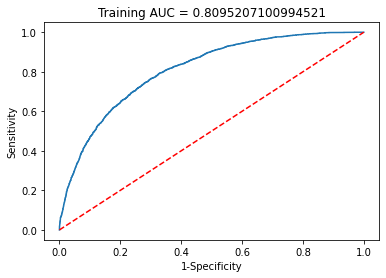

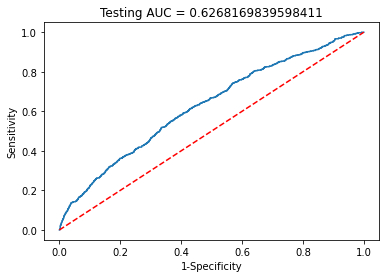

In [17]:
predictions = clf.predict_proba(X_train)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_train), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(y_train), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("Training AUC = {}".format(auc))
plt.savefig("train.png")
plt.show()


predictions = clf.predict_proba(X_test)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(np.asarray(y_test), predictions[:, 1])
auc = metrics.roc_auc_score(np.asarray(y_test), predictions[:, 1])
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("1-Specificity")
plt.ylabel("Sensitivity")
plt.title("Testing AUC = {}".format(auc))
plt.savefig("test.png")
plt.show()


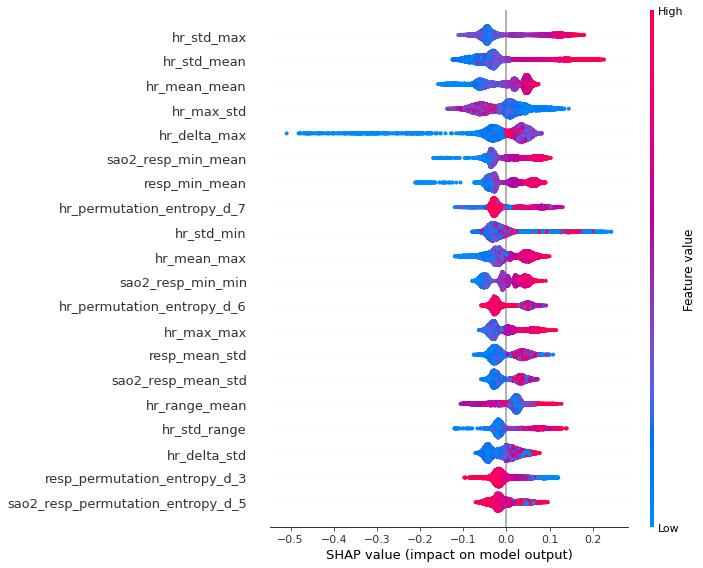

In [18]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, show=False)
plt.savefig("shap.png", bbox_inches="tight")